### Stock Prediction - Using Neural Networks - TensorFlow

Tutorial based on the following [source](https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877)

#### 1. Initial - The usual

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot

Load data

In [2]:
# Prepare data
data = pd.read_csv("../data/data_stocks.csv")

# Drop the date variable
data = data.drop(['DATE'],1)

# Get the dimensions
n = data.shape[0]
p = data.shape[1]

File was apparently cleaned and hence there is no need to adjust for any missing values etc.
Just visualize the SP500 data 

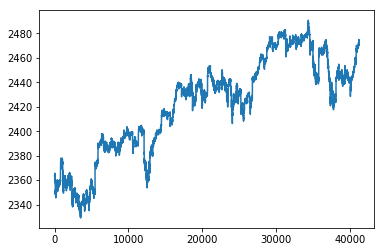

In [3]:
# Check the timeseries plot of the data
pyplot.plot(data['SP500'])

In [4]:
# Change the data to numpy array
data = data.values

#### 2. Divide the data into training and testing datasets

In [5]:
# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))

test_start = train_end
test_end = n

data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

#### 3. Scaling data
This is because most of the activation functions of the network's neurons are tanh/sigmoid functions which are defined on [-1,1] or [0,1] intervals 

#### 3.1. Some preliminary details of deep neural networks
AnalyticsVidhya has decent article on the same and it is shared [here](https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/). Most of the content below is from that article.

0. What does a deep neural net look like?
   <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/10/13170054/nn.png" alt="Activation function" height="100" width="500"/>

1. Design of a single neuron in the neural network
   <img src="https://dzone.com/storage/temp/5939898-artificialneuron.jpg" alt="Activation function" height="100" width="400"/>

2. Each neuron has the following:
   1. Weight
   2. Bias
   3. Activation Function
   
   Neurons do a linear transformation on the input by the weights and biases. The non linear transformation is done by the activation function. i.e. without the activation function, the weights and bias would just do a linear transformation of input.  A neural network without an activation function would just be a linear regression model. Activation function is what allows the neural network to learn.


3. Forward propagation and backward propagation (of information)

   Forward movement of information (from input to output) known as the forward propagation. But what if the output generated is far away from the expected value? In a neural network, we would update the weights and biases of the neurons on the basis of the error. This process is known as back-propagation. Once the entire data has gone through this process, the final weights and biases are used for predictions.
   

4. Activation function
   <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/10/17123344/act.png" alt="Activation function" height="100" width="400"/>
   The activation function is the non linear transformation that we do over the input signal. This transformed output is then sen to the next layer of neurons as input. Activation functions make the back-propagation possible since the gradients are supplied along with the error to update the weights and biases
   
   
5. Popular types of [activation functions](https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/)
   
   1. <b> Binary step-function  </b>
   
   This is a threshold based classifier i.e. it decides whether or not the neuron should be activated. If the value Y is above a given threshold value then activate the neuron else leave it deactivated. Useful for binary classification problems. The article above has an error where it calls the gradient of this step-function as zero. It is incorrect as the derivative of the step function is an impulse (dirac delta function). But I think the point the article makes is that the gradient is not so useful when back-propagated.
   
   2. <b>Linear function</b>
   
   Function can be simply be described as f(x)=ax. Here the activation is proportional to input i.e. input x, will be transformed to ax. This can be applied to various neurons and multiple neurons can be activated at the same time. Now, when we have multiple classes, we can choose the one which has the maximum value. But the derivate of this function is constant (a) and hence this gradient does not aid in back-propagation of information. Ultimately how-many ever linear transformations we make, the result is a linear transform and hence is useful when we need to interpret the results (just like linear regression).
   
   3. <b>Sigmoid</b>
   
   f(x)=1/(1+e^-x. It is a smooth function and is continuously differentiable. Output is going to be non-linear. As per the article, the goodness of using a sigmoid is that, the derivative is a normal curve with high values between -3 and +3. This means that in this range small changes in x would also bring about large changes in the value of Y. So the function essentially tries to push the Y values towards the extremes. This is a very desirable quality when we’re trying to classify the values to a particular class. Gradient is dependent on x and hence is useful during back propagation. Problems associated with it is that the values only range from 0 to 1. This means that the sigmoid function is not symmetric around the origin and the values received are all positive. So not all times would we desire the values going to the next neuron to be all of the same sign. This can be addressed by scaling the sigmoid function. That’s exactly what happens in the tanh function.
      
   4. <b>Tanh</b>
   
   The tanh function is very similar to the sigmoid function. It is actually just a scaled version of the sigmoid function. tanh(x)=2sigmoid(2x)-1. Tanh works similar to the sigmoid function but is symmetric over the origin. it ranges from -1 to 1. All other properties are the same as that of the sigmoid function. It is continuous and differentiable at all points. The function as you can see is non linear so we can easily backpropagate the errors. The gradient of the tanh function is steeper as compared to the sigmoid function. Our choice of using sigmoid or tanh would basically depend on the requirement of gradient in the problem statement. But similar to the sigmoid function we still have the vanishing gradient problem (read below). The graph of the tanh function is flat and the gradients are very low.
   
   5. <b> ReLU </b>
   
   The ReLU function is the Rectified linear unit. It is the most widely used activation function. It is defined as f(x)=max(0,x). ReLU is the most widely used activation function while designing networks today. First things first, the ReLU function is non linear, which means we can easily backpropagate the errors and have multiple layers of neurons being activated by the ReLU function. The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time. i.e. if the input is negative it will convert it to zero and the neuron does not get activated. This means that at a time only a few neurons are activated making the network sparse making it efficient and easy for computation. But ReLU also has gradients moving towards zero. i.e. on the negative side of the graph, the gradient is zero, which means for activations in that region, the gradient is zero and the weights are not updated during back propagation. This can create dead neurons which never get activated.
   
   6. <b> Leaky ReLU </b>
   
   f(x)= {ax when x<0; = x when x>=0} And a is a very small number. The main advantage of replacing the horizontal line is to remove the zero gradient. So in this case the gradient of the left side of the graph is non zero and so we would no longer encounter dead neurons in that region. 
   
   7. <b> Parameterized ReLU </b>
   
   Same as above. i.e. f(x)= {ax when x<0; = x when x>=0}. But 'a' is also a trainable paramter in this model. The network also learns the value of 'a' for faster and more optimum convergence. The parametrised ReLU function is used when the leaky ReLU function still fails to solve the problem of dead neurons and the relevant information is not successfully passed to the next layer.
   
   8. <b> Softmax </b>
   
   The softmax function is also a type of sigmoid function but is handy when we are trying to handle classification problems. Sigmoid can only handle two classes (i.e. binary classification). But in here, softmax gives the probability of which class the input might belong to. 
   
   <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/10/17014509/softmax.png" alt="softmax" height="100" width="250"/>
   
   For example: if we have the outputs as [1.2 , 0.9 , 0.75], then after applying softmax we would get the following: [0.42 ,  0.31, 0.27]. So now we can use these as probabilities for the value to be in each class. <b>The softmax function is ideally used in the output layer of the classifier where we are actually trying to attain the probabilities to define the class of each input.</b>
  
  
6. Choice of Activation Function

   According to the article, the following is the logic / heuristics to know which activation function should be used in which situation. They call it rule-of-thumb.

    1. Sigmoid functions and their combinations generally work better in the case of classifiers
    2. Sigmoids and tanh functions are sometimes avoided due to the vanishing gradient problem
    3. ReLU function is a general activation function and is used in most cases these days
    4. If we encounter a case of dead neurons in our networks the leaky ReLU function is the best choice
    5. Always keep in mind that ReLU function should only be used in the hidden layers
    6. As a rule of thumb, you can begin with using ReLU function and then move over to other activation functions in case ReLU doesn’t provide with optimum results
    

7. Vanishing Gradient problem - [In Detail](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)

   The vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly. 

In [ ]:
# Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]